<a href="https://colab.research.google.com/github/Siddhant-Thendral-Arasu/Siddhant-Thendral-Arasu/blob/road_semantic_segmentation/road_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Road semantic segmentation using U-Net

In [ ]:
Using Kitti dataset from https://www.cvlibs.net/datasets/kitti/eval_semseg.php?benchmark=semantics2015.
Let us check basics are OK.

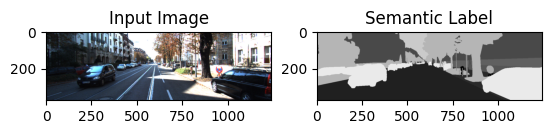

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Load an input image
img = cv2.imread(r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\training\image_2\000000_10.png')
# Load its semantic label
label = cv2.imread(r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\training\semantic\000000_10.png', cv2.IMREAD_GRAYSCALE)

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Semantic Label")
plt.imshow(label, cmap="gray")
plt.show()

In [ ]:
Now, that the dataset validation is satisfactory, let us get images, labels of training dataset.

In [ ]:
import os
import tensorflow as tf

def preprocess_image_label(image_path, label_path, img_size=(128, 128)):
    # Load and resize the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, img_size)
    image = image / 255.0  # Normalize

    # Load and resize the label
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)
    label = tf.image.resize(label, img_size, method="nearest")

    return image, label

def load_dataset(img_dir, label_dir, img_size=(128, 128)):
    images = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.png')])
    labels = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(lambda x, y: preprocess_image_label(x, y, img_size))
    dataset = dataset.batch(8).shuffle(buffer_size=100)

    return dataset

# Load training data
train_dataset = load_dataset(r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\training\image_2', r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\training\semantic')

In [ ]:
Need to get the number of semantic labels available in this dataset

In [ ]:
import os
import numpy as np
from PIL import Image

# Path to the semantic mask folder
semantic_folder = r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\training\semantic'
# Initialize a set to store unique class labels
unique_classes = set()

# Iterate through all mask files
for mask_file in os.listdir(semantic_folder):
    mask_path = os.path.join(semantic_folder, mask_file)
    mask = np.array(Image.open(mask_path))  # Load mask as a numpy array
    unique_classes.update(np.unique(mask))  # Add unique pixel values to the set

# Number of unique classes
num_classes = len(unique_classes)
print("Number of Classes:", num_classes)
print("Class Labels:", unique_classes)

Number of Classes: 31
Class Labels: {np.uint8(0), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9), np.uint8(10), np.uint8(11), np.uint8(12), np.uint8(13), np.uint8(14), np.uint8(15), np.uint8(16), np.uint8(17), np.uint8(18), np.uint8(19), np.uint8(20), np.uint8(21), np.uint8(22), np.uint8(23), np.uint8(24), np.uint8(25), np.uint8(26), np.uint8(27), np.uint8(28), np.uint8(29), np.uint8(30), np.uint8(31), np.uint8(32), np.uint8(33)}


In [ ]:
Let us build and compile model. Using size 128 as 512 consumes excessive memory.

In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 3), num_classes=2):
    inputs = layers.Input(input_shape)
    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    # Decoder
    c2 = layers.Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding='same')(p1)
    outputs = layers.Activation('softmax')(c2)

    model = models.Model(inputs, outputs)
    return model

model = build_unet(num_classes=34)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 128, 128, 34)        │          19,618 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 128, 128, 34)        │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,410 (83.63 KB)

 Trainable params: 21,410 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(train_dataset, epochs=20, steps_per_epoch=len(train_dataset))

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.1582 - loss: 3.4000
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.2986 - loss: 2.6104  
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.2866 - loss: 2.3533  
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.2965 - loss: 2.2508  
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4142 - loss: 2.2090  
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.4961 - loss: 2.0803  
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.4515 - loss: 2.0219
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - accuracy: 0.4644 - loss: 2.0342
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.4847 - loss: 1.9722 
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5252 - loss: 1.8750
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - accuracy: 0.4802 - loss: 1.8525 
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/st

In [ ]:
Let us predict using test dataset

In [ ]:
from PIL import Image
import numpy as np

test_dir = r'C:\Users\Siddhant\Documents\Python\project7\data_semantics\testing\image_2'
test_dataset = sorted([os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')])

# Define preprocessing function
def preprocess_image(image_path, target_size=(128, 128)):
    img = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    img = img.resize(target_size)  # Resize to model's input size
    img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Preprocess all test images
test_images = np.array([preprocess_image(img_path, target_size=(128, 128)) for img_path in test_dataset])
print(test_images.shape)

(200, 128, 128, 3)


In [ ]:
# Ensure input shape is correct (e.g., add batch dimension if necessary)
test_images = np.expand_dims(test_images, axis=0) if len(test_images.shape) == 3 else test_images
print(test_images.shape)

(200, 128, 128, 3)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


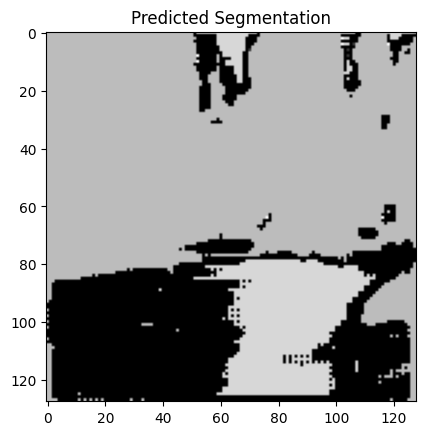

In [ ]:
predictions = model.predict(test_images)

# Visualize a prediction
plt.imshow(predictions[0].argmax(axis=-1), cmap="gray")
plt.title("Predicted Segmentation")
plt.show()